# Modeling

## Library + Data Setting.

In [1]:
# !pip install lightgbm

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [2]:
# Visualization
import matplotlib.font_manager as fm

# 나눔 폰트 경로 설정
font_path = '/Library/Fonts/NanumGothic.ttf'

# 나눔 폰트 설정
fe = fm.FontEntry(
    fname=font_path,  # ttf 파일이 저장되어 있는 경로
    name='NanumGothic'  # 이 폰트의 원하는 이름 설정
)
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'})  # 폰트 설정
plt.rc('font', family='NanumGothic')

### Selective Data Load

In [3]:
train_data = pd.read_csv('./data/train_cho.csv')
test_data = pd.read_csv('./data/test_cho.csv')

In [3]:
train_data = pd.read_csv('./data/train_final_1.csv')
test_data = pd.read_csv('./data/test_final_1.csv')

In [4]:
train_data.columns

Index(['아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)',
       'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수',
       'k-건설사(시공사)', 'k-시행사', 'k-연면적', 'k-주거전용면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '건축면적', '주차대수',
       '기타/의무/임대/임의=1/2/3/4', '좌표X', '좌표Y', 'target', 'distance_score', '구',
       '동', '계약연도', '계약월', '급지', 'address', '신축여부', '이자율', 'is_top20',
       '대장아파트_거리'],
      dtype='object')

In [5]:
import re
# 특수 문자 제거 또는 대체 함수
def clean_column_name(name):
   return re.sub(r'[^a-zA-Z0-9가-힣]', '_', name)

# 모든 열 이름을 정리
train_data.columns = [clean_column_name(col) for col in train_data.columns]
test_data.columns = [clean_column_name(col) for col in test_data.columns]

In [6]:
train_data.columns

Index(['아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k_단지분류_아파트_주상복합등등_',
       'k_세대타입_분양형태_', 'k_관리방식', 'k_복도유형', 'k_난방방식', 'k_전체동수', 'k_전체세대수',
       'k_건설사_시공사_', 'k_시행사', 'k_연면적', 'k_주거전용면적', 'k_전용면적별세대현황_60_이하_',
       'k_전용면적별세대현황_60__85_이하_', 'k_85__135_이하', 'k_135_초과', '건축면적', '주차대수',
       '기타_의무_임대_임의_1_2_3_4', '좌표X', '좌표Y', 'target', 'distance_score', '구',
       '동', '계약연도', '계약월', '급지', 'address', '신축여부', '이자율', 'is_top20',
       '대장아파트_거리'],
      dtype='object')

In [7]:
train_data.shape

(1118822, 39)

### 범주형/연속형/전용면적 로그 처리등

In [7]:
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in train_data.columns:
    if pd.api.types.is_numeric_dtype(train_data[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k_전체동수', 'k_전체세대수', 'k_연면적', 'k_주거전용면적', 'k_전용면적별세대현황_60_이하_', 'k_전용면적별세대현황_60__85_이하_', 'k_85__135_이하', 'k_135_초과', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'distance_score', '계약연도', '계약월', '신축여부', '이자율', 'is_top20', '대장아파트_거리']
범주형 변수: ['아파트명', '도로명', 'k_단지분류_아파트_주상복합등등_', 'k_세대타입_분양형태_', 'k_관리방식', 'k_복도유형', 'k_난방방식', 'k_건설사_시공사_', 'k_시행사', '기타_의무_임대_임의_1_2_3_4', '구', '동', '급지', 'address']


In [8]:
# train과 test 데이터를 합쳐서 하나의 데이터프레임으로 만듭니다.
combined_data = pd.concat([train_data, test_data], axis=0)

#전용면적 로그 변환
combined_data['전용면적'] = np.log1p(combined_data['전용면적'])

# 각 범주형 변수에 대해 LabelEncoder를 적용합니다.
label_encoders = {}

for col in categorical_columns_v2:
    lbl = LabelEncoder()
    combined_data[col] = combined_data[col].astype(str)  # 데이터 타입을 문자열로 변환
    combined_data[col] = lbl.fit_transform(combined_data[col])
    label_encoders[col] = lbl  # 나중에 후처리를 위해 레이블인코더를 저장해둡니다.

# 인코딩된 데이터를 다시 train과 test 데이터로 나눕니다.
train_data_encoded = combined_data.iloc[:len(train_data)]
test_data_encoded = combined_data.iloc[len(train_data):]

In [9]:
test_data_encoded.shape

(9272, 39)

# lightGBM

#### feature importance

In [33]:
# Target과 독립변수들을 분리해줍니다.
y = train_data_encoded['target']
X = train_data_encoded.drop(['target'], axis=1)

In [34]:
import joblib

# Permutation Importance 함수 정의
def permutation_importance(model, X, y, metric, num_rounds=5):
    print("Calculating baseline score...")
    baseline_score = metric(y, model.predict(X, num_iteration=model.best_iteration))
    importances = []

    for col in X.columns:
        print(f"Evaluating feature: {col}")
        scores = []
        for _ in range(num_rounds):
            X_permuted = X.copy()
            X_permuted[col] = np.random.permutation(X_permuted[col])
            score = metric(y, model.predict(X_permuted, num_iteration=model.best_iteration))
            scores.append(score)
        importances.append(np.mean(scores) - baseline_score)

    feature_importances = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    return feature_importances

# 데이터 나누기
print("Splitting data into train and test sets...")
X_train_perm, X_test_perm, y_train_perm, y_test_perm = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM 데이터셋 생성
print("Creating LightGBM dataset...")
dtrain_perm = lgb.Dataset(X_train_perm, label=y_train_perm)
dtest_perm = lgb.Dataset(X_test_perm, label=y_test_perm, reference=dtrain_perm)

# 하이퍼파라미터 설정
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
}

# num_boost_round 설정
num_boost_round = 10000

# Detailed logging callback
def log_callback(env):
    if env.iteration % 1000 == 0 or env.iteration + 1 == env.end_iteration:
        print(f"Iteration {env.iteration + 1}: Train RMSE = {env.evaluation_result_list[0][2]}, Valid RMSE = {env.evaluation_result_list[1][2]}")

print("Training the final model...")
final_model_perm = lgb.train(
    params,
    dtrain_perm,
    num_boost_round=num_boost_round,
    valid_sets=[dtrain_perm, dtest_perm],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), 
               lgb.log_evaluation(period=10),
               log_callback]
)

# Permutation Importance 계산
print("Calculating Permutation Importance...")
feature_importances = permutation_importance(final_model_perm, X_test_perm, y_test_perm, mean_squared_error)

print("Permutation Feature Importances:")
print(feature_importances)


Splitting data into train and test sets...
Creating LightGBM dataset...
Training the final model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5331
[LightGBM] [Info] Number of data points in the train set: 895057, number of used features: 38
[LightGBM] [Info] Start training from score 58003.281782
Iteration 1: Train RMSE = 42946.20594246705, Valid RMSE = 43217.78038602651
Training until validation scores don't improve for 50 rounds
[10]	train's rmse: 24956.1	valid's rmse: 25226.3
[20]	train's rmse: 17755.7	valid's rmse: 18009.3
[30]	train's rmse: 14640.6	valid's rmse: 14880.3
[40]	train's rmse: 13085.1	valid's rmse: 13321
[50]	train's rmse: 12145	valid's rmse: 12382.2
[60]	train's rmse: 11499	valid's rmse: 11743.8
[70]	train's rmse: 11002.5	valid's rmse: 11257.8
[80]	train's rm

In [37]:
feature_importances.dtypes

feature        object
importance    float64
dtype: object

DataFrame columns: Index(['feature', 'importance'], dtype='object')
Permutation Feature Importances:
                   feature    importance
0                     계약년월  1.045655e+09
1                     전용면적  9.756646e+08
2                       급지  6.113884e+08
3                     건축년도  1.695819e+08
4                      좌표Y  1.136631e+08
5                      좌표X  6.300580e+07
6                  address  5.447845e+07
7                        구  2.346532e+07
8                 대장아파트_거리  2.164844e+07
9                        층  1.891177e+07
10                   k_연면적  1.570995e+07
11                  k_전체동수  1.222237e+07
12                       동  1.209701e+07
13                    주차대수  1.160945e+07
14      k_단지분류_아파트_주상복합등등_  1.124049e+07
15                  k_난방방식  1.095110e+07
16                k_주거전용면적  1.078178e+07
17          distance_score  8.790410e+06
18                     도로명  7.312892e+06
19                    아파트명  6.965256e+06
20                     이자율  5.912753e+

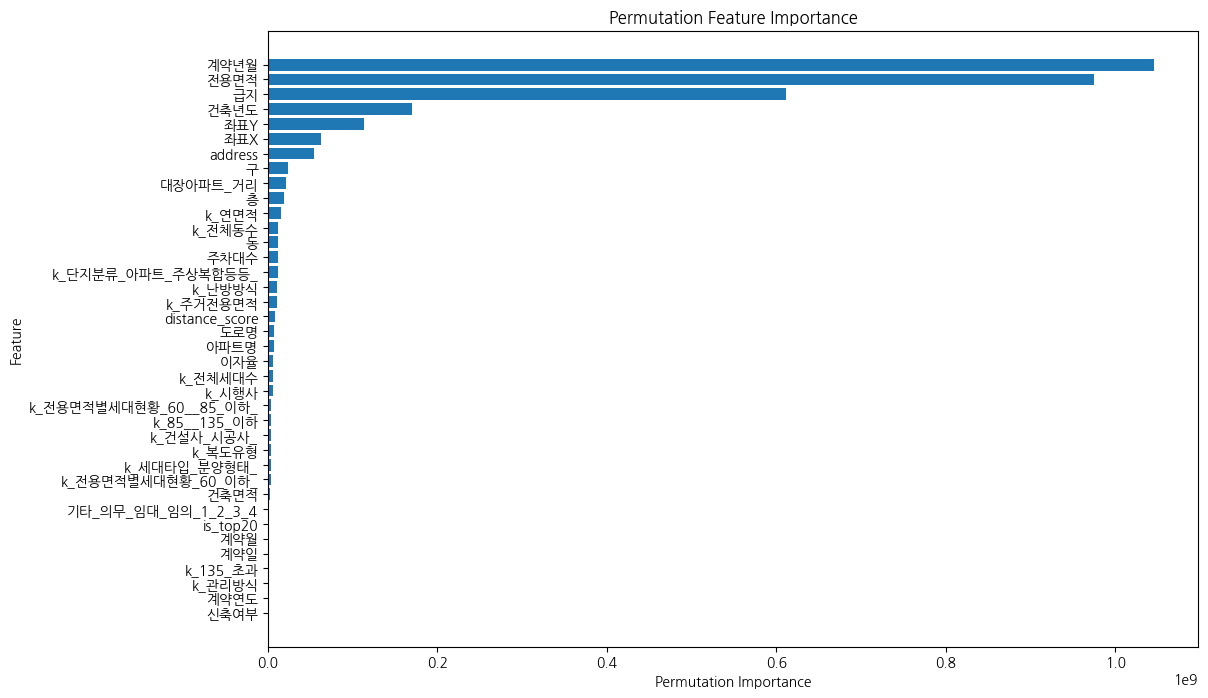

In [42]:
print("DataFrame columns:", feature_importances.columns)

# 중요도 순으로 정렬
importance_df = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)

print("Permutation Feature Importances:")
print(importance_df)

# DataFrame을 CSV 파일로 저장
importance_df.to_csv('feature_importances.csv', index=False)
print("Feature importances saved to 'feature_importances.csv'")

# 결과 시각화
print("Visualizing feature importances...")
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [44]:
# CSV 파일 불러오기
importance_df = pd.read_csv('feature_importances.csv')

# 중요도 순으로 정렬
feature_importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

print("Feature Importance DataFrame:")
print(feature_importance_df)

Feature Importance DataFrame:
                   feature    importance
0                     계약년월  1.045655e+09
1                     전용면적  9.756646e+08
2                       급지  6.113884e+08
3                     건축년도  1.695819e+08
4                      좌표Y  1.136631e+08
5                      좌표X  6.300580e+07
6                  address  5.447845e+07
7                        구  2.346532e+07
8                 대장아파트_거리  2.164844e+07
9                        층  1.891177e+07
10                   k_연면적  1.570995e+07
11                  k_전체동수  1.222237e+07
12                       동  1.209701e+07
13                    주차대수  1.160945e+07
14      k_단지분류_아파트_주상복합등등_  1.124049e+07
15                  k_난방방식  1.095110e+07
16                k_주거전용면적  1.078178e+07
17          distance_score  8.790410e+06
18                     도로명  7.312892e+06
19                    아파트명  6.965256e+06
20                     이자율  5.912753e+06
21                 k_전체세대수  5.691434e+06
22                   k_시행사 

## Feature Select & LightGBM Feature Optimization  

In [2]:
import wandb


# 특성 중요도에 따라 정렬된 특성 리스트 (이전 코드에서 얻은 결과)
sorted_features = feature_importance_df['feature'].tolist()

# RMSE 값을 저장할 리스트
rmse_scores = []

# 특성 개수 범위 설정
feature_counts = range(9, 31, 3)

for feature_count in feature_counts:
    print(f"Training with top {feature_count} features")
    # 상위 n개의 특성 선택
    selected_features = sorted_features[:feature_count]
    X_selected = X[selected_features]
    
    # 데이터 분할
    X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # wandb 초기화
    wandb.init(
        project="re_price_prediction",
        group="features_final",
        name=f"top_{feature_count}_features",
        reinit=True,
        config={
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'n_estimators': 10000,
            'learning_rate': 0.1,
            # 'num_leaves': 107,
            # 'max_depth': 10,
            # 'min_child_samples': 8,
            # 'subsample': 0.5668227534307944,
            # 'colsample_bytree': 0.6033862727269486,
            # 'reg_alpha': 2.5906244698002496e-06,
            # 'reg_lambda': 2.979573198070953e-05,
            'force_col_wise': True,
        }
    )
    
    # 파라미터 정의
    params = wandb.config
    
    # LGBMRegressor 모델 생성
    gbm = lgb.LGBMRegressor(**params)
    
    # Callback function to log evaluation metrics to wandb
    def log_to_wandb(env):
        for data_name, eval_name, eval_result, _ in env.evaluation_result_list:
            metric_name = f"{data_name}_{eval_name}"
            wandb.log({metric_name: eval_result})
    
    # 모델 학습
    gbm.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_metric='rmse',
            categorical_feature="auto",
            callbacks=[lgb.early_stopping(stopping_rounds=50),
                       lgb.log_evaluation(period=10, show_stdv=True),
                       log_to_wandb])
    
    # 검증 세트에 대한 RMSE 계산
    y_pred = gbm.predict(X_val)
    rmse = np.sqrt(np.mean((y_val - y_pred)**2))
    rmse_scores.append(rmse)
    
    print(f"RMSE with {feature_count} features: {rmse}")
    
    # wandb run 종료
    wandb.finish()

# 최적의 특성 개수 찾기
best_feature_count = feature_counts[np.argmin(rmse_scores)]
best_rmse = min(rmse_scores)

print(f"Best number of features: {best_feature_count}")
print(f"Best RMSE: {best_rmse}")

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, rmse_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Features')
plt.annotate(f'Best: {best_feature_count} features\nRMSE: {best_rmse:.4f}', 
             xy=(best_feature_count, best_rmse), 
             xytext=(5, 5), 
             textcoords='offset points')
plt.grid(True)
plt.show()

# 최적의 특성 리스트 출력
best_features = sorted_features[:best_feature_count]
print("Best features:")
for i, feature in enumerate(best_features, 1):
    print(f"{i}. {feature}")

NameError: name 'feature_importance_df' is not defined

### best features 자동/수동 설정

In [14]:
# CSV 파일 불러오기
importance_df = pd.read_csv('feature_importances.csv')

# 중요도 순으로 정렬
feature_importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

print("Feature Importance DataFrame:")
print(feature_importance_df)

sorted_features = feature_importance_df['feature'].tolist()

#display(best_feature_count)
best_feature_count = 18
best_features = sorted_features[:best_feature_count]
display(best_features)

Feature Importance DataFrame:
                   feature    importance
0                     계약년월  1.045655e+09
1                     전용면적  9.756646e+08
2                       급지  6.113884e+08
3                     건축년도  1.695819e+08
4                      좌표Y  1.136631e+08
5                      좌표X  6.300580e+07
6                  address  5.447845e+07
7                        구  2.346532e+07
8                 대장아파트_거리  2.164844e+07
9                        층  1.891177e+07
10                   k_연면적  1.570995e+07
11                  k_전체동수  1.222237e+07
12                       동  1.209701e+07
13                    주차대수  1.160945e+07
14      k_단지분류_아파트_주상복합등등_  1.124049e+07
15                  k_난방방식  1.095110e+07
16                k_주거전용면적  1.078178e+07
17          distance_score  8.790410e+06
18                     도로명  7.312892e+06
19                    아파트명  6.965256e+06
20                     이자율  5.912753e+06
21                 k_전체세대수  5.691434e+06
22                   k_시행사 

['계약년월',
 '전용면적',
 '급지',
 '건축년도',
 '좌표Y',
 '좌표X',
 'address',
 '구',
 '대장아파트_거리',
 '층',
 'k_연면적',
 'k_전체동수',
 '동',
 '주차대수',
 'k_단지분류_아파트_주상복합등등_',
 'k_난방방식',
 'k_주거전용면적',
 'distance_score']

In [50]:
# 최적의 특성 리스트 생성
X_final = X[best_features]
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [ ]:
wandb.init(
    project="re_price_prediction",
    group="lightBGM",
    name="final_model",
    reinit=True,
    config=params
)

final_model = lgb.LGBMRegressor(**params)

final_model.fit(X_train_final, y_train_final,
                eval_set=[(X_train_final, y_train_final), (X_val_final, y_val_final)],
                eval_metric='rmse',
                categorical_feature="auto",
                callbacks=[lgb.early_stopping(stopping_rounds=50),
                           lgb.log_evaluation(period=10, show_stdv=True),
                           log_to_wandb])

wandb.finish()

# 모델 저장
import joblib
joblib.dump(final_model, 'final_model.joblib')
print("Final model saved as 'final_model.joblib'")



#### 결과 확인

In [22]:
import time

# 실제 테스트 데이터에 대한 예측
print("Predicting on test data...")
start_time = time.time()
X_test = test_data_encoded.drop(['target'], axis=1)

# 테스트 데이터에서 최적의 특성만 선택
X_test_selected = X_test[best_features]

# 최적의 반복 횟수로 X_test에 대한 예측 수행
real_test_pred = final_model.predict(X_test_selected, num_iteration=final_model.best_iteration_)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

print("Predictions:")
print(real_test_pred)

# 예측 결과를 DataFrame으로 변환하고 CSV 파일로 저장
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)
print("Predictions saved to 'output.csv'")

Predicting on test data...
Execution time: 11.49 seconds
Predictions:
[176361.47002299 285797.6445489  315441.53519327 ...  81097.01363005
  69827.85753275  71823.36769997]
Predictions saved to 'output.csv'


In [7]:
# CSV 파일 불러오기
importance_df = pd.read_csv('feature_importances.csv')

# 중요도 순으로 정렬
feature_importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
sorted_features = feature_importance_df['feature'].tolist()

#display(best_feature_count)
best_feature_count = 21
best_features = sorted_features[:best_feature_count]
display(best_features)

['계약년월',
 '전용면적',
 '급지',
 '건축년도',
 '좌표Y',
 '좌표X',
 'address',
 '구',
 '대장아파트_거리',
 '층',
 'k_연면적',
 'k_전체동수',
 '동',
 '주차대수',
 'k_단지분류_아파트_주상복합등등_',
 'k_난방방식',
 'k_주거전용면적',
 'distance_score',
 '도로명',
 '아파트명',
 '이자율']

## lightGBM + Sweep : 하이퍼파라미터 최적화

In [8]:
# Target과 독립변수들을 분리해줍니다.
y = train_data_encoded['target']
X = train_data_encoded.drop(['target'], axis=1)

X_final = X[best_features]
X_train, X_val, y_train, y_val = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [ ]:
import optuna
import wandb
import time

# 새로운 W&B 백엔드 사용
wandb.require("core")

def objective():
    with wandb.init(project="re_price_prediction", group="lightGBM sweep 3", job_type="optimize"):
        config = wandb.config
        
        params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'n_estimators': config.n_estimators,
            'num_leaves': config.num_leaves,
            'max_depth': config.max_depth,
            'learning_rate': config.learning_rate,
            'min_child_samples': config.min_child_samples,
            'subsample': config.subsample,
            'colsample_bytree': config.colsample_bytree,
            'reg_alpha': config.reg_alpha,
            'reg_lambda': config.reg_lambda,
            'force_col_wise': True,
        }
        
        gbm = lgb.LGBMRegressor(**params)
        
        gbm.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_metric='rmse',
            categorical_feature="auto",
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(period=10),
            ]
        )
        
        val_preds = gbm.predict(X_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
        
        wandb.log({"val_rmse": val_rmse})
        
        return val_rmse

sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_rmse',
        'goal': 'minimize'
    },
    'parameters': {
        'n_estimators': {'distribution': 'int_uniform', 'min': 19000, 'max': 20000},
        'num_leaves': {'distribution': 'int_uniform', 'min': 96, 'max': 128},
        'max_depth': {'distribution': 'int_uniform', 'min': 9, 'max': 10},
        'learning_rate': {'distribution': 'uniform', 'min': 0.01, 'max': 0.02},
        'min_child_samples': {'distribution': 'int_uniform', 'min': 5, 'max': 100},
        'subsample': {'distribution': 'uniform', 'min': 0.5, 'max': 1.0},
        'colsample_bytree': {'distribution': 'uniform', 'min': 0.5, 'max': 1.0},
        'reg_alpha': {'distribution': 'uniform', 'min': 0, 'max': 1},
        'reg_lambda': {'distribution': 'uniform', 'min': 0, 'max': 1},
    }
}

sweep_id = wandb.sweep(sweep_config, project="re_price_prediction")

# Sweep 실행
wandb.agent(sweep_id, function=objective, count=37)

# Sweep이 완료될 때까지 대기
print("Waiting for sweep to complete...")
time.sleep(60)  # 60초 대기, 필요에 따라 조정

# 최적의 하이퍼파라미터로 최종 모델 학습
api = wandb.Api()
sweep = api.sweep(f"ml9_regression/re_price_prediction/{sweep_id}")
best_run = sweep.best_run()
best_config = best_run.config

with wandb.init(project="re_price_prediction", config=best_config, group="lightGBM sweep", job_type="train"):
    config = wandb.config
    
    final_params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': config.n_estimators,
        'num_leaves': config.num_leaves,
        'max_depth': config.max_depth,
        'learning_rate': config.learning_rate,
        'min_child_samples': config.min_child_samples,
        'subsample': config.subsample,
        'colsample_bytree': config.colsample_bytree,
        'reg_alpha': config.reg_alpha,
        'reg_lambda': config.reg_lambda,
        'force_col_wise': True,
    }
    
    final_model = lgb.LGBMRegressor(**final_params)
    
    final_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric='rmse',
        categorical_feature="auto",
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=10),
        ]
    )
    
    final_val_preds = final_model.predict(X_val)
    final_val_rmse = np.sqrt(mean_squared_error(y_val, final_val_preds))
    wandb.log({"final_val_rmse": final_val_rmse})
    
    print(f"Final Validation RMSE: {final_val_rmse}")

    # 테스트 세트에 대한 예측 및 RMSE 계산 
    #     test_preds = final_model.predict(X_test)
    #     test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    #     wandb.log({"test_rmse": test_rmse})
    #     print(f"Test RMSE: {test_rmse}")

## Simple lightGBM

#### data type minizatoin
- 데이터 컬럼 확인할것!

In [35]:
# 데이터 타입 최적화
# for df in [train_data_encoded, test_data_encoded]:
#     df['아파트명'] = df['아파트명'].astype('int16')
#     df['전용면적'] = df['전용면적'].astype('float32')
#     df['층'] = df['층'].astype('int8')
#     df['건축년도'] = df['건축년도'].astype('int16')
#     df['도로명'] = df['도로명'].astype('int32')
#     df['k-복도유형'] = df['k-복도유형'].astype('int8')
#     df['k-난방방식'] = df['k-난방방식'].astype('int8')
#     df['k-전체세대수'] = df['k-전체세대수'].astype('float32')
#     df['주차대수'] = df['주차대수'].astype('float32')
#     df['기타/의무/임대/임의=1/2/3/4'] = df['기타/의무/임대/임의=1/2/3/4'].astype('int8')
#     df['좌표X'] = df['좌표X'].astype('float32')
#     df['좌표Y'] = df['좌표Y'].astype('float32')
#     df['target'] = df['target'].astype('float32')
#     df['계약연도'] = df['계약연도'].astype('int16')
#     df['계약월'] = df['계약월'].astype('int8')
#     df['구'] = df['구'].astype('int8')
#     df['동'] = df['동'].astype('int16')
#     df['distance_score'] = df['distance_score'].astype('int8')
#     df['급지'] = df['급지'].astype('int8')

In [ ]:
# !pip install wandb #wandb login...

In [17]:
# Target과 독립변수들을 분리해줍니다.
y = train_data_encoded['target']
X = train_data_encoded.drop(['target'], axis=1)

X_final = X[best_features]

In [19]:
X_train.columns

Index(['계약년월', '전용면적', '급지', '건축년도', '좌표Y', '구', '좌표X', '층', 'k_연면적',
       'distance_score', 'k_난방방식', 'k_단지분류_아파트_주상복합등등_', '동', '주차대수', '도로명'],
      dtype='object')

In [ ]:
import wandb
from datetime import datetime

run_name = f"lightGBM_final_{datetime.now().strftime('%m%d_%H%M')}"

# Start a new wandb run to track this script
wandb.init(
    project="re_price_prediction",
    group="lightGBM final",
    name=run_name,
    config={
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': 100000,
        'learning_rate': 0.01,  # 최적화된 learning_rate 사용
        'num_leaves': 108,        # 최적화된 num_leaves 사용
        'max_depth': 10,          # 최적화된 max_depth 사용
        #'min_child_samples': 8,
        #'subsample': 0.5668227534307944,
        #'colsample_bytree': 0.6033862727269486,
        #'reg_alpha': 2.5906244698002496e-06,
        #'reg_lambda': 2.979573198070953e-05,
        #'force_col_wise': True,
    }
)

# 파라미터 정의
params = wandb.config

# Define the LightGBM regressor
gbm = lgb.LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    learning_rate=0.01,
    n_estimators=100000,
    metric='rmse',
)

# Callback function to log evaluation metrics to wandb
def log_to_wandb(env):
    for data_name, eval_name, eval_result, stdv in env.evaluation_result_list:
        metric_name = f"{data_name}_{eval_name}"
        wandb.log({metric_name: eval_result})

# Fit the model
gbm.fit(
    X_train, y_train,
    eval_set=[[X_train, y_train], [X_val, y_val]],
    eval_metric='rmse',
    categorical_feature="auto",
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=10, show_stdv=True),
        log_to_wandb
    ]
)

# [optional] finish the wandb run
wandb.finish()


In [ ]:
%%time
X_test = test_data_encoded.drop(['target'], axis=1)
# 최적의 반복 횟수로 X_test에 대한 예측 수행
real_test_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print(real_test_pred)
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=True)

[191522.14239343 275602.71543252 327149.71025315 ...  80560.99953826
  68044.8291902   68190.79535061]
CPU times: user 9.34 s, sys: 172 ms, total: 9.51 s
Wall time: 1.93 s


## lightGBM + final parmameter tunning

In [9]:
# CSV 파일 불러오기
importance_df = pd.read_csv('feature_importances.csv')

# 중요도 순으로 정렬
feature_importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
sorted_features = feature_importance_df['feature'].tolist()

#display(best_feature_count)
best_feature_count = 21
best_features = sorted_features[:best_feature_count]
display(best_features)

['계약년월',
 '전용면적',
 '급지',
 '건축년도',
 '좌표Y',
 '좌표X',
 'address',
 '구',
 '대장아파트_거리',
 '층',
 'k_연면적',
 'k_전체동수',
 '동',
 '주차대수',
 'k_단지분류_아파트_주상복합등등_',
 'k_난방방식',
 'k_주거전용면적',
 'distance_score',
 '도로명',
 '아파트명',
 '이자율']

In [10]:
# Target과 독립변수들을 분리해줍니다.
y = train_data_encoded['target']
X = train_data_encoded.drop(['target'], axis=1)

X_final = X[best_features]

In [14]:
X_final.columns

Index(['계약년월', '전용면적', '급지', '건축년도', '좌표Y', '좌표X', 'address', '구', '대장아파트_거리',
       '층', 'k_연면적', 'k_전체동수', '동', '주차대수', 'k_단지분류_아파트_주상복합등등_', 'k_난방방식',
       'k_주거전용면적', 'distance_score', '도로명', '아파트명', '이자율'],
      dtype='object')

In [11]:
import wandb
import time
from datetime import datetime

# WandB 초기화
run_name = f"lightGBM_final_{datetime.now().strftime('%m%d_%H%M')}"
wandb.init(
    project="re_price_prediction",
    group="lightGBM final",
    name=run_name,
    reinit=True,
    config={
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': 100000,
        #'learning_rate': 0.2,
        #'num_leaves': 98,
        #'max_depth': 6,
        #'subsample': 0.64,
        #'colsample_bytree': 0.64,
        #'min_data_in_leaf': 1144,
        'force_col_wise': True,
    }
)

# 파라미터 정의
params = wandb.config

# 전체 학습 데이터 준비
y = train_data_encoded['target']
X = train_data_encoded.drop(['target'], axis=1)
X_final = X[best_features]

# LGBMRegressor 모델 생성
gbm = lgb.LGBMRegressor(**params)

# Callback function to log evaluation metrics to wandb
def log_to_wandb(env):
    for data_name, eval_name, eval_result, stdv in env.evaluation_result_list:
        metric_name = f"{data_name}_{eval_name}"
        wandb.log({metric_name: eval_result})

# 전체 데이터로 모델 학습
print("Training on full dataset...")
gbm.fit(X_final, y,
        eval_set=[(X_final, y)],
        eval_metric='rmse',
        categorical_feature="auto",
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=50, show_stdv=True),
                   log_to_wandb])

# 최종 RMSE 계산
final_train_preds = gbm.predict(X_final)
final_train_rmse = np.sqrt(mean_squared_error(y, final_train_preds))
wandb.log({"final_train_rmse": final_train_rmse})
print(f"Final Training RMSE: {final_train_rmse}")



# WandB 실행 종료
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: paanmego (ml9_regression). Use `wandb login --relogin` to force relogin


Training on full dataset...
[LightGBM] [Info] Total Bins 3504
[LightGBM] [Info] Number of data points in the train set: 1118822, number of used features: 21
[LightGBM] [Info] Start training from score 57991.532149
[50]	training's rmse: 12272.3
[100]	training's rmse: 10138.9
[150]	training's rmse: 9228.9
[200]	training's rmse: 8641.78
[250]	training's rmse: 8194.92
[300]	training's rmse: 7874.87
[350]	training's rmse: 7621.31
[400]	training's rmse: 7379.78
[450]	training's rmse: 7187.15
[500]	training's rmse: 7018.09
[550]	training's rmse: 6862.44
[600]	training's rmse: 6735.12
[650]	training's rmse: 6608.43
[700]	training's rmse: 6501.39
[750]	training's rmse: 6408.79
[800]	training's rmse: 6325.92
[850]	training's rmse: 6242.29
[900]	training's rmse: 6169.58
[950]	training's rmse: 6101.21
[1000]	training's rmse: 6035.22
[1050]	training's rmse: 5972.69
[1100]	training's rmse: 5914.4
[1150]	training's rmse: 5857.47
[1200]	training's rmse: 5801.24
[1250]	training's rmse: 5745.98
[1300]	t

In [ ]:
# 실제 테스트 데이터에 대한 예측
print("Predicting on test data...")
start_time = time.time()

X_test = test_data_encoded.drop(['target'], axis=1)
X_test_selected = X_test[best_features]

real_test_pred = gbm.predict(X_test_selected)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

print("Predictions:")
print(real_test_pred)

# 예측 결과를 DataFrame으로 변환하고 CSV 파일로 저장
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)
print("Predictions saved to 'output.csv'")

# Time based Ensemble

In [ ]:
# Target과 독립변수들을 분리해줍니다.
y = train_data_encoded['target']
X = train_data_encoded.drop(['target'], axis=1)

X = X[best_features]
y = y[best_features]

X = X.sort_values(by=['계약년', '계약월'])

In [ ]:
# 가중치 부여 함수
def assign_weight(year):
    if year >= 2020:
        return 2
    elif year >= 2018:
        return 1.5
    else:
        return 1

X['weight'] = X['계약년'].apply(assign_weight)

# LightGBM 모델 설정
def create_model():
    return LGBMRegressor(
        objective='regression',
        boosting_type='gbdt',
        n_estimators=100000,
        learning_rate=0.05,
        num_leaves=31,
        feature_fraction=0.9,
        bagging_fraction=0.8,
        bagging_freq=5,
        verbose=-1
    )

# 폴드 1: 2007-2011 데이터로 2012 예측
X_train_1 = X[(X['계약년'] >= 2007) & (X['계약년'] <= 2011)]
y_train_1 = y[X_train_1.index]
X_val_1 = X[X['계약년'] == 2012]
y_val_1 = y[X_val_1.index]

model_1 = create_model()
model_1.fit(
    X_train_1.drop(['계약년월', 'weight'], axis=1),
    y_train_1,
    eval_set=[(X_val_1.drop(['계약년월', 'weight'], axis=1), y_val_1)],
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbose=100,
    sample_weight=X_train_1['weight']
)

# 폴드 2: 2018-2022 데이터로 2023 예측
X_train_2 = X[(X['계약년'] >= 2018) & (X['계약년'] <= 2022)]
y_train_2 = y[X_train_2.index]
X_val_2 = X[X['계약년'] == 2023]
y_val_2 = y[X_val_2.index]

model_2 = create_model()
model_2.fit(
    X_train_2.drop(['계약년월', 'weight'], axis=1),
    y_train_2,
    eval_set=[(X_val_2.drop(['계약년월', 'weight'], axis=1), y_val_2)],
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbose=100,
    sample_weight=X_train_2['weight']
)

# 2023년 예측
future_data = X[X['계약년'] == 2023]

# 앙상블 예측
y_pred_1 = model_1.predict(future_data.drop(['계약년월', 'weight'], axis=1))
y_pred_2 = model_2.predict(future_data.drop(['계약년월', 'weight'], axis=1))
y_future_pred = (y_pred_1 + y_pred_2) / 2  # 간단한 평균 앙상블

# 결과 저장
results = pd.DataFrame({
    '계약년월': future_data['계약년월'],
    '예측가격': y_future_pred
})
results.to_csv('future_predictions_ensemble.csv', index=False)
print("2023년 예측 완료. 'future_predictions_ensemble.csv'에 저장되었습니다.")

# 각 모델의 성능 평가
rmse_1 = np.sqrt(mean_squared_error(y_val_1, model_1.predict(X_val_1.drop(['계약년월', 'weight'], axis=1))))
rmse_2 = np.sqrt(mean_squared_error(y_val_2, model_2.predict(X_val_2.drop(['계약년월', 'weight'], axis=1))))

print(f"모델 1 (2007-2011 -> 2012) RMSE: {rmse_1}")
print(f"모델 2 (2018-2022 -> 2023) RMSE: {rmse_2}")

### 결과확인

In [ ]:
# 앙상블 모델 생성
def ensemble_predict(model1, model2, X):
    pred1 = model1.predict(X, num_iteration=model1.best_iteration_)
    pred2 = model2.predict(X, num_iteration=model2.best_iteration_)
    return (pred1 + pred2) / 2


# 테스트 데이터에 시계열 특성 추가 (년, 월만)
X_test['계약년'] = pd.to_datetime(X['계약년월']).dt.year
X_test['계약월'] = pd.to_datetime(X['계약년월']).dt.month

# 앙상블 예측 수행
real_test_pred = ensemble_predict(model_1, model_2, X_test.drop(['계약년월'], axis=1))

print("테스트 데이터에 대한 예측 결과:")
print(real_test_pred)

# 예측 결과를 DataFrame으로 변환
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])

# 결과를 CSV 파일로 저장
preds_df.to_csv('output.csv', index=True)
print("예측 결과가 'output.csv' 파일로 저장되었습니다.")

# 각 모델의 성능 평가 (2023년 데이터에 대해)
X_val_2023 = X[X['계약년'] == 2023].drop(['계약년월', 'weight'], axis=1)
y_val_2023 = y[X[X['계약년'] == 2023].index]

rmse_1 = np.sqrt(mean_squared_error(y_val_2023, model_1.predict(X_val_2023)))
rmse_2 = np.sqrt(mean_squared_error(y_val_2023, model_2.predict(X_val_2023)))
rmse_ensemble = np.sqrt(mean_squared_error(y_val_2023, ensemble_predict(model_1, model_2, X_val_2023)))

print(f"모델 1 (2007-2011 -> 2023) RMSE: {rmse_1}")
print(f"모델 2 (2018-2022 -> 2023) RMSE: {rmse_2}")
print(f"앙상블 모델 (2023) RMSE: {rmse_ensemble}")

# catBoost

In [ ]:
# !pip install catboost

### Simple catBoost

In [5]:
from catboost import CatBoostRegressor, Pool
# Prepare the training data
y = house_data['target']
X = house_data.drop(['target'], axis=1)

# Handle outliers in '전용면적' and apply log transformation
def handle_outliers_and_log_transform(df, column):
    # # Calculate the upper limit for outliers (using IQR)
    # Q1 = df[column].quantile(0.25)
    # Q3 = df[column].quantile(0.75)
    # IQR = Q3 - Q1
    # upper_limit = Q3 + 1.5 * IQR
    
    # # Cap the outliers
    # df[column] = np.where(df[column] > upper_limit, upper_limit, df[column])
    
    # Apply log transformation
    df[column] = np.log1p(df[column])
    return df

X = handle_outliers_and_log_transform(X, '전용면적')

In [ ]:
# 각 열의 결측치 개수 확인
missing_data = house_data.isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0]  # 결측치가 있는 열만 표시

print("결측치 개수:")
print(missing_data)

# 결측치를 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_data.index, y=missing_data.values)
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values per Column')
plt.xticks(rotation=45)
plt.show()

In [7]:
# Handle missing values
X = X.fillna('missing')

In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype == 'object']

# CatBoost Pool 생성
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
val_pool = Pool(X_val, y_val, cat_features=categorical_features)


# CatBoost 모델 정의
model = CatBoostRegressor(
    iterations=1000,
    depth=10,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=50
)

# 모델 학습
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    cat_features=categorical_features,  
    use_best_model=True,
    verbose=10,  
)


### catBoost + optuna

In [ ]:
from catboost import CatBoostRegressor, Pool

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype == 'object']

# CatBoost Pool 생성
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
val_pool = Pool(X_val, y_val, cat_features=categorical_features)

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 3000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50)
    }

    model = CatBoostRegressor(
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=42,
        **params
    )

    model.fit(
        train_pool,
        eval_set=val_pool,
        use_best_model=True,
        verbose=0
    )

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

# Optuna 학습 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# 최적의 하이퍼파라미터 출력
print('Best trial:')
trial = study.best_trial
print('RMSE: {}'.format(trial.value))
print('Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# 최적의 하이퍼파라미터로 최종 모델 학습
best_params = study.best_params
best_model = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    **best_params
)

best_model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    verbose=10
)

# XGBoost

In [25]:
# Target과 독립변수들을 분리해줍니다.
y_train = train_data_encoded['target']
X_train = train_data_encoded.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
import wandb
import xgboost as xgb


# WandB 초기화
wandb.init(
    project="re_price_prediction",
    group="xgboost",
    reinit=True,
    config={
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 12,
        'learning_rate': 0.01,
        'n_estimators': 100000,
    }
)

params = dict(wandb.config)


# DMatrix 생성
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# 사용자 정의 WandB 콜백 함수 정의
class WandbCallback(xgb.callback.TrainingCallback):
    def after_iteration(self, model, epoch, evals_log):
        for data_name, eval_metrics in evals_log.items():
            for metric_name, scores in eval_metrics.items():
                wandb.log({f"{data_name}_{metric_name}": scores[-1], "iteration": epoch})
        return False

# 모델 학습
watchlist = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(params, dtrain, evals=watchlist, num_boost_round=100000, early_stopping_rounds=50, callbacks=[WandbCallback()])

# 예측 및 평가
# val_preds = model.predict(dval)
# final_rmse = mean_squared_error(y_val, val_preds, squared=False)
# wandb.log({'final_val_rmse': final_rmse})

# WandB 실행 종료
wandb.finish()

In [35]:
%%time
X_test = test_data_encoded.drop(['target'], axis=1)
dtest = xgb.DMatrix(X_test)

real_test_pred = model.predict(dtest)
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)

print(real_test_pred)

[189626.67 252217.7  325632.72 ...  87333.41  72458.06  74300.24]
CPU times: user 3.88 s, sys: 0 ns, total: 3.88 s
Wall time: 419 ms


## XGBoost + RandomizedSearchCV

In [ ]:
import wandb
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer

# WandB 초기화
wandb.init(
    project="re_price_prediction",
    group="xgboost",
    reinit=True,
    config={
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 12,
        'learning_rate': 0.01,
        'n_estimators': 100000,
    }
)

params = dict(wandb.config)

# Target과 독립변수들을 분리해줍니다.
y_train = train_data_encoded['target']
X_train = train_data_encoded.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# DMatrix 생성
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# 사용자 정의 WandB 콜백 함수 정의
class WandbCallback(xgb.callback.TrainingCallback):
    def after_iteration(self, model, epoch, evals_log):
        for data_name, eval_metrics in evals_log.items():
            for metric_name, scores in eval_metrics.items():
                wandb.log({f"{data_name}_{metric_name}": scores[-1], "iteration": epoch})
        return False

# 하이퍼파라미터 범위 정의
param_dist = {
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 500, 1000],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# XGBoost 모델 생성
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=50, scoring=make_scorer(mean_squared_error, squared=False), cv=3, verbose=1, n_jobs=-1, random_state=42)

# RandomizedSearchCV 실행 및 WandB 로깅
def wandb_random_search_logging(cv_results):
    for i in range(len(cv_results['params'])):
        wandb.log({
            'iteration': i,
            'mean_test_score': cv_results['mean_test_score'][i],
            'std_test_score': cv_results['std_test_score'][i],
            'params': cv_results['params'][i]
        })

random_search.fit(X_train, y_train)
wandb_random_search_logging(random_search.cv_results_)

# 최적의 하이퍼파라미터 출력
best_params = random_search.best_params_
wandb.log({'best_params': best_params})
print("Best parameters found: ", best_params)

# 최적의 하이퍼파라미터로 모델 학습
watchlist = [(dtrain, 'train'), (dval, 'eval')]
best_params['eval_metric'] = 'rmse'  # eval_metric 추가
model = xgb.train(best_params, dtrain, evals=watchlist, num_boost_round=100000, early_stopping_rounds=50, callbacks=[WandbCallback()])

# 예측 및 평가
val_preds = model.predict(dval)
final_rmse = mean_squared_error(y_val, val_preds, squared=False)
wandb.log({'final_val_rmse': final_rmse})

# 테스트 데이터 예측 및 결과 저장
X_test = test_data_encoded.drop(['target'], axis=1)
dtest = xgb.DMatrix(X_test)

real_test_pred = model.predict(dtest)
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)

print(real_test_pred)

# WandB 실행 종료
wandb.finish()


# K-Fold Cross-validation

### lightGBM + K-Fold Holdout

In [ ]:
y = train_data_encoded['target']
X = train_data_encoded.drop(['target'], axis=1)

X_final = X[best_features]
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import KFold
import time

# WandB 초기화
wandb.init(
    project="re_price_prediction",
    group="k-fold holdout",
    reinit=True,
    config={
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': 100000,
        'learning_rate': 0.010204448913134991,
        'num_leaves': 128,
        'max_depth': 10,
        'min_child_samples': 8,
        'subsample': 0.5668227534307944,
        'colsample_bytree': 0.6033862727269486,
        'reg_alpha': 2.5906244698002496e-06,
        'reg_lambda': 2.979573198070953e-05,
        'force_row_wise': True,
    }
)

# 파라미터 정의
params = wandb.config

# 데이터 준비
y = train_data_encoded['target']
X = train_data_encoded.drop(['target'], axis=1)
X_final = X[best_features]

# Holdout set 생성
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_final, y, test_size=0.2, random_state=42)

# K-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# K-Fold 교차 검증 실행
fold = 1
for train_index, val_index in kf.split(X_train_final):
    X_train_fold, X_val_fold = X_train_final.iloc[train_index], X_train_final.iloc[val_index]
    y_train_fold, y_val_fold = y_train_final.iloc[train_index], y_train_final.iloc[val_index]
    
    # LGBMRegressor 모델 생성
    gbm = lgb.LGBMRegressor(**params)
    
    # 모델 학습
    gbm.fit(X_train_fold, y_train_fold,
            eval_set=[(X_train_fold, y_train_fold), (X_val_fold, y_val_fold)],
            eval_metric='rmse',
            categorical_feature="auto",
            callbacks=[lgb.early_stopping(stopping_rounds=50),
                       lgb.log_evaluation(period=10, show_stdv=True)])
    
    # 검증 결과 WandB에 로그
    val_preds = gbm.predict(X_val_fold)
    val_rmse = mean_squared_error(y_val_fold, val_preds, squared=False)
    wandb.log({f'fold_{fold}_val_rmse': val_rmse})
    
    fold += 1

# 최종 홀드아웃 세트에 대한 평가
final_val_preds = gbm.predict(X_val_final)
final_val_rmse = mean_squared_error(y_val_final, final_val_preds, squared=False)
wandb.log({'final_holdout_rmse': final_val_rmse})

# [optional] finish the wandb run
wandb.finish()

In [ ]:
# 실제 테스트 데이터에 대한 예측
print("Predicting on test data...")
start_time = time.time()

X_test = test_data_encoded.drop(['target'], axis=1)
X_test_selected = X_test[best_features]

real_test_pred = gbm.predict(X_test_selected, num_iteration=gbm.best_iteration_)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

print("Predictions:")
print(real_test_pred)

# 예측 결과를 DataFrame으로 변환하고 CSV 파일로 저장
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)
print("Predictions saved to 'output.csv'")

### lightGBM + TimeSeriesSplit

In [ ]:
# Target과 독립변수들을 분리해줍니다.
y = train_data_encoded['target']
X = train_data_encoded.drop(['target'], axis=1)

In [ ]:
X.columns

In [6]:
X = X.sort_values(by=['계약년', '계약월'])

In [ ]:
train_data_encoded.head()

In [8]:
from sklearn.model_selection import TimeSeriesSplit


# TimeSeriesSplit을 사용한 시계열 교차 검증
tscv = TimeSeriesSplit(n_splits=5)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.010204448913134991,
    'num_leaves': 128,
    'max_depth': 10,
    'min_child_samples': 8,
    'subsample': 0.5668227534307944,
    'colsample_bytree': 0.6033862727269486,
    'reg_alpha': 2.5906244698002496e-06,
    'reg_lambda': 2.979573198070953e-05,
    'force_row_wise': True,
}

# K-Fold 교차 검증 실행
fold = 1
rmse_scores = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)
    
    # 모델 학습
    model = lgb.train(params, dtrain, num_boost_round=100000, valid_sets=[dtrain, dval], valid_names=['train', 'valid'], early_stopping_rounds=50, verbose_eval=10)
    
    # 예측 및 평가
    val_preds = model.predict(X_val, num_iteration=model.best_iteration)
    val_rmse = mean_squared_error(y_val, val_preds, squared=False)
    rmse_scores.append(val_rmse)
    print(f"Fold {fold}: Validation RMSE = {val_rmse}")
    fold += 1

print(f"Mean Validation RMSE: {np.mean(rmse_scores)}")

# 최종 모델 학습 (전체 데이터를 사용)
dtrain_final = lgb.Dataset(X, label=y)
final_model = lgb.train(params, dtrain_final, num_boost_round=1000)

# 미래 데이터 예측 (2023년 7월부터 9월까지)
# X_future = pd.read_csv('future_data.csv')
# future_preds = final_model.predict(X_future)

# 결과 출력
# print("Future Predictions:")
# print(future_preds)

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2155
[LightGBM] [Info] Number of data points in the train set: 124318, number of used features: 18
[LightGBM] [Info] Start training from score 36842.178550
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 24983.6	valid_1's rmse: 34322.8
[20]	training's rmse: 23286.7	valid_1's rmse: 32109.5
[30]	training's rmse: 21881.1	valid_1's rmse: 30291.4
[40]	training's rmse: 20658.1	valid_1's rmse: 28732.9
[50]	training's rmse: 19320.4	valid_1's rmse: 27014.6
[60]	training's rmse: 18176.5	valid_1's rmse: 25529.2
[70]	training's rmse: 17011.6	valid_1's rmse: 24026.2
[80]	training's rmse: 16137.9	valid_1's rmse: 22875
[90]	training's rmse: 15253.1	valid_1's rmse: 21709.5
[100]	training's rmse: 14452.6	valid_

### lightGBM + Stratified KFold

### lightGBM + Random seed KFold

In [66]:

# 데이터 분리
y_train = train_data_encoded['target']
X_train = train_data_encoded.drop(['target'], axis=1)

# 사용할 특성 정의 (모든 열을 사용한다고 가정)
features = X_train.columns.tolist()

# 여러 시드 설정
seeds = [i for i in range(10)]  # [0~9]
n_folds = 5

all_oofs = []
all_total_predicts = []
RMSEs = []

for seed in seeds:
    print(f"-------- Seed {seed} --------")
    
    # StratifiedKFold 설정
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    # y_train을 구간으로 나누어 분류 레이블 생성
    cut_y_train = pd.cut(y_train, 1000, labels=False)
    
    seed_oofs = np.zeros(len(X_train))
    
    for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(X_train, cut_y_train)):
        print(f"-------- Fold {fold_idx} --------")
        
        kfold_X_train = X_train.iloc[train_idx][features]
        kfold_y_train = y_train.iloc[train_idx]
        kfold_X_valid = X_train.iloc[valid_idx][features]
        kfold_y_valid = y_train.iloc[valid_idx]
        
        dtrain = lgb.Dataset(kfold_X_train, label=kfold_y_train)
        dvalid = lgb.Dataset(kfold_X_valid, label=kfold_y_valid, reference=dtrain)
        
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'n_estimators': 1000,
            'learning_rate': 0.05,
            'subsample': 0.7,
            'subsample_freq': 1,
            'random_state': seed
        }
        
        model = lgb.train(
            params,
            dtrain,
            num_boost_round=1000,
            valid_sets=[dtrain, dvalid],
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False),
                       lgb.log_evaluation(period=100)]
        )
        
        seed_oofs[valid_idx] = model.predict(kfold_X_valid, num_iteration=model.best_iteration)
    
    all_oofs.append(seed_oofs)
    
    # RMSE 계산
    fold_rmse = np.sqrt(mean_squared_error(y_train, seed_oofs))
    RMSEs.append(fold_rmse)
    print(f"Seed {seed} OOF RMSE: {fold_rmse}")

# 최종 OOF 예측 및 RMSE 계산
final_oof_predictions = np.mean(all_oofs, axis=0)
final_oof_rmse = np.sqrt(mean_squared_error(y_train, final_oof_predictions))
print(f"최종 OOF RMSE: {final_oof_rmse}")

# 전체 데이터로 최종 모델 학습
dtrain_full = lgb.Dataset(X_train, label=y_train)
final_model = lgb.train(params, dtrain_full, num_boost_round=model.best_iteration)
print("모델 학습이 완료되었습니다.")

# 테스트 데이터에 대한 예측 (테스트 데이터가 있다고 가정)
# X_test = test_data[features]
# final_predictions = final_model.predict(X_test, num_iteration=final_model.best_iteration)

-------- Seed 0 --------
-------- Fold 0 --------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2887
[LightGBM] [Info] Number of data points in the train set: 124052, number of used features: 18
[LightGBM] [Info] Start training from score 91035.553091
[100]	training's rmse: 18200.9	valid_1's rmse: 18597.9
[200]	training's rmse: 14842.1	valid_1's rmse: 15458.4
[300]	training's rmse: 13176.1	valid_1's rmse: 13920.9
[400]	training's rmse: 12136.8	valid_1's rmse: 12985.3
[500]	training's rmse: 11392.5	valid_1's rmse: 12327.1
[600]	training's rmse: 10825.9	valid_1's rmse: 11851.9
[700]	training's rmse: 10328.6	valid_1's rmse: 11432.6
[800]	training's rmse: 9903.71	valid_1's rmse: 11083
[900]	training's rmse: 9567.46	valid_1's rmse: 10812.9
[1000]	training's rmse: 9271.44	valid_1's rmse

# GAN ML

In [39]:

# Target과 독립변수들을 분리해줍니다.
y_train = train_data_encoded['target']
X_train = train_data_encoded.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [41]:
y_train.shape

(895057,)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import wandb

# wandb 초기화
wandb.init(
    project="apartment_price_prediction_gan",
    config={
        "g_learning_rate": 0.01,
        "d_learning_rate": 0.01,
        "batch_size": 32,
        "epochs": 100,
    }
)

# 특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# PyTorch 텐서로 변환
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1)

# 데이터셋 및 데이터로더 생성
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=wandb.config.batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=wandb.config.batch_size)

# 생성자 모델 정의
class Generator(nn.Module):
    def __init__(self, input_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# 판별자 모델 정의
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + 1, 128),  # input_dim + 1 for price
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 모델 및 옵티마이저 초기화
generator = Generator(15)  # 15 features
discriminator = Discriminator(15)  # 15 features
g_optimizer = optim.Adam(generator.parameters(), lr=wandb.config.g_learning_rate)
d_optimizer = optim.Adam(discriminator.parameters(), lr=wandb.config.d_learning_rate)
loss_fn = nn.BCELoss()

# wandb에 모델 가중치 로깅 설정
wandb.watch(generator, log="all", log_freq=10)
wandb.watch(discriminator, log="all", log_freq=10)

# 훈련 함수
def train(epochs):
    for epoch in range(epochs):
        generator.train()
        discriminator.train()
        
        for real_features, real_prices in train_dataloader:
            batch_size = real_features.size(0)
            
            # 판별자 훈련
            d_optimizer.zero_grad()
            
            fake_prices = generator(real_features)
            real_combined = torch.cat((real_features, real_prices), 1)
            fake_combined = torch.cat((real_features, fake_prices), 1)
            
            real_predictions = discriminator(real_combined)
            fake_predictions = discriminator(fake_combined.detach())
            
            real_loss = loss_fn(real_predictions, torch.ones_like(real_predictions))
            fake_loss = loss_fn(fake_predictions, torch.zeros_like(fake_predictions))
            d_loss = real_loss + fake_loss
            
            d_loss.backward()
            d_optimizer.step()
            
            # 생성자 훈련
            g_optimizer.zero_grad()
            
            fake_prices = generator(real_features)
            fake_combined = torch.cat((real_features, fake_prices), 1)
            fake_predictions = discriminator(fake_combined)
            
            g_loss = loss_fn(fake_predictions, torch.ones_like(fake_predictions))
            
            g_loss.backward()
            g_optimizer.step()

        # 검증
        generator.eval()
        discriminator.eval()
        val_g_loss = 0
        val_d_loss = 0
        with torch.no_grad():
            for val_features, val_prices in val_dataloader:
                fake_prices = generator(val_features)
                real_combined = torch.cat((val_features, val_prices), 1)
                fake_combined = torch.cat((val_features, fake_prices), 1)
                
                real_predictions = discriminator(real_combined)
                fake_predictions = discriminator(fake_combined)
                
                val_d_loss += (loss_fn(real_predictions, torch.ones_like(real_predictions)) + 
                               loss_fn(fake_predictions, torch.zeros_like(fake_predictions))).item()
                val_g_loss += loss_fn(fake_predictions, torch.ones_like(fake_predictions)).item()

        val_g_loss /= len(val_dataloader)
        val_d_loss /= len(val_dataloader)

        # wandb에 로그 기록
        wandb.log({
            "epoch": epoch + 1,
            "train_g_loss": g_loss.item(),
            "train_d_loss": d_loss.item(),
            "val_g_loss": val_g_loss,
            "val_d_loss": val_d_loss,
        })
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train G Loss: {g_loss.item():.4f}, Train D Loss: {d_loss.item():.4f}, "
                  f"Val G Loss: {val_g_loss:.4f}, Val D Loss: {val_d_loss:.4f}")

# 모델 훈련
train(wandb.config.epochs)

# 가격 예측
generator.eval()
with torch.no_grad():
    test_features = X_val_tensor[:5]  # 검증 데이터의 처음 5개 샘플 사용
    predicted_prices = generator(test_features)
    actual_prices = y_val_tensor[:5]

print("실제 가격:", actual_prices.numpy().flatten())
print("예측 가격:", predicted_prices.numpy().flatten())

# wandb 실행 종료
wandb.finish()

## Model Dump & Load

In [67]:
import joblib

# 모델 저장
model_filename = 'final_model.pkl'
joblib.dump(final_model, model_filename)
print("모델이 저장되었습니다.")

모델이 저장되었습니다.


In [68]:
# 모델 불러오기
final_model = joblib.load(model_filename)
print("모델이 불러와졌습니다.")

# 테스트 데이터 로드 및 전처리
X_test = test_data_encoded.drop(['target'], axis=1)

# 최적의 반복 횟수로 X_test에 대한 예측 수행
real_test_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration)

print("테스트 데이터에 대한 예측이 완료되었습니다.")

모델이 불러와졌습니다.
테스트 데이터에 대한 예측이 완료되었습니다.


In [21]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=True)

In [20]:
real_test_pred

array([186820.0053029 , 281186.82354398, 342517.38743919, ...,
        85472.85710872,  67089.15922442,  62128.35332279])

In [63]:
real_test_pred

array([177477.82484663, 266527.08642075, 332481.69242302, ...,
        78170.09201322,  64776.73065125,  59279.72447601])

### feature select.

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Permutation Importance 함수 정의
def permutation_importance(model, X, y, metric, num_rounds=5):
    baseline_score = metric(y, model.predict(X, num_iteration=model.best_iteration))
    importances = []

    for col in X.columns:
        scores = []
        for _ in range(num_rounds):
            X_permuted = X.copy()
            X_permuted[col] = np.random.permutation(X_permuted[col])
            score = metric(y, model.predict(X_permuted, num_iteration=model.best_iteration))
            scores.append(score)
        importances.append(np.mean(scores) - baseline_score)

    feature_importances = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    return feature_importances

# train 데이터와 test 데이터를 나눕니다.
X_train_perm, X_test_perm, y_train_perm, y_test_perm = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 최종 모델 학습 (train 데이터로만 학습)
dtrain_perm = lgb.Dataset(X_train_perm, label=y_train_perm)
final_model_perm = lgb.train(best_params, dtrain_perm, num_boost_round=model.best_iteration)

# Permutation Importance 계산
feature_importances = permutation_importance(final_model_perm, X_test_perm, y_test_perm, mean_squared_error)

print("Permutation Feature Importances:")
print(feature_importances)

# 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance")
plt.gca().invert_yaxis()
plt.show()